In [174]:
# duh
import numpy as np
import pandas as pd
# plot
import matplotlib.pyplot as plt
import matplotlib as mpl
# gibberish
import re 
# scikit
from sklearn import svm
from sklearn.model_selection import train_test_split

# get data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# combine it
data = [train, test]

train.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [175]:
# clean up time
for dataset in data:
    # math
    avg = dataset['Age'].mean()
    std = dataset['Age'].std()
    null_count = dataset['Age'].isnull().sum()
    
    # generate and replace missing ages with rdm ones based on stats
    random_ages = np.random.randint(avg - std, avg + std, size=null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = random_ages
    dataset['Age'] = dataset['Age'].astype(int)

# does being older make you more likely to die? ...yes
train['AgeImpact'] = pd.cut(train['Age'], 5)
age_survival = train[['AgeImpact', 'Survived']].groupby(['AgeImpact'], as_index=False).mean()

# do it again for embarking
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
embarked_survival = train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

In [176]:
# $$$
train['FareImpact'] = pd.qcut(train['Fare'], 4)
fare_survival = train[['FareImpact', 'Survived']].groupby(['FareImpact'], as_index=False).mean()

# am I a loner
for dataset in data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
for dataset in data:
    dataset['Loner'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'Loner'] = 1
alone_survival = train[['Loner', 'Survived']].groupby(['Loner'], as_index=False).mean()

# am I important 
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

for dataset in data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# how important exactly?
for dataset in data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Jonkheer',
                                                'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Dona'],)
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
title_survival = train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

In [177]:
for dataset in data:
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1})

    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':3, 'Mythical':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2})
    
# drop undesireables #1-7
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch', 'FamilySize', 'FareImpact', 'AgeImpact', 'Title', 'Loner' ], axis=1) # 'Title', 'Loner'
test_no_id = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch', 'FamilySize', 'Title', 'Loner'], axis=1) 

train.head()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Loner,Title
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,NaN,2,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,363272,0,NaN,0,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,3,0,0,240276,1,NaN,2,1,1,1
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,1,NaN,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,1,NaN,0,3,0,3


Pclass importance score: 0.19625027545524687
Sex importance score: 0.46395696885188864
Age importance score: 0.1382738720246547
Fare importance score: 0.13115433521642614
Embarked importance score: 0.07036454845178367
['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']


<BarContainer object of 5 artists>

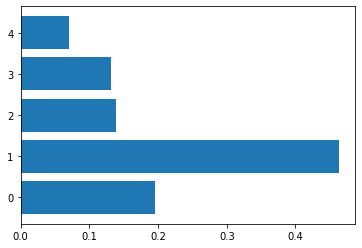

In [178]:
# find importance
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(train.iloc[:, 1:], train.iloc[:, 0])
for name, score in zip(test_no_id.head(), rnd_clf.feature_importances_):
  print(f"{name} importance score: {score}")
print(list(train.columns))
plt.barh(range(len(rnd_clf.feature_importances_)), rnd_clf.feature_importances_)

In [179]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

RANDOM_SEED = 42

X = train.iloc[:, 1:]
y = train.iloc[:, 0]
estimators = [
              ('rf', RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)),
              ('svr', make_pipeline(StandardScaler(),
              AdaBoostClassifier(DecisionTreeClassifier(random_state=RANDOM_SEED), random_state=RANDOM_SEED, learning_rate=0.1)),
              GradientBoostingClassifier(random_state=RANDOM_SEED),
              ExtraTreesClassifier(random_state=RANDOM_SEED),
                                    LinearSVC(random_state=RANDOM_SEED))
]
stk_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_SEED)
print(stk_clf.fit(X_train, y_train).score(X_test, y_test))
stk_clf.fit(X_train, y_train)

prediction = stk_clf.predict(test_no_id)[:, np.newaxis]
prediction = np.hstack((test['PassengerId'][:, np.newaxis], prediction))
# it is decidely so
output = pd.DataFrame({'PassengerId':prediction[:, 0], 'Survived':prediction[:, 1]})
output.to_csv('testensemble.csv', index=False)

output.head()

0.7892376681614349


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# drop it like it's hot
X_train = train.drop(labels=["Survived"], axis = 1)
Y_train = train["Survived"]
IDtest = test["PassengerId"]
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch', 'FamilySize', 'Title', 'Loner'], axis=1) 

# banana split 
kfold = StratifiedKFold(n_splits=10)

In [ ]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_




In [ ]:
# extra trees 
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_


In [ ]:
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [ ]:
# boost it
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

In [ ]:
# support vector
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

In [180]:
# 8ball will my code work?
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

# Expropriate!
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

test_Survived = pd.Series(votingC.predict(test), name="Survived")

# It is decidedly so
results = pd.concat([IDtest,test_Survived],axis=1)
results.to_csv("ensemble_titanic.csv",index=False)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
Fitting 10 folds for each of 54 candidates, totalling 540 fits
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done 533 out of 540 | elapsed:   32.5s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   32.7s finished
Fitting 10 folds for each of 54 candidates, totalling 540 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done 533 out of 540 | elapsed:   37